The purpose of this notebook is to follow along with the logic of calling the command from terminal. You are able to train the model from running these cells top to bottom. Please do note that I have not solved the issue where the inferred images are zoomed in.

# Imports

There is also a file named `requirements.txt`, which will install all dependencies required for training to work.

Note: Mask-RCNN does **NOT** work with Tensorflow 2. This notebook has been run with:

- Python 3.7
- Tensorflow 1.15.0 (or tensorflow-gpu)
- Keras 2.4.5

In [1]:
IMAGE_MAX_DIM = 512

In [2]:
import tensorflow as tf
# Feel free to change the config.gpu_options.per_process_gpu_memory_fraction to an appropriate percentage
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# tf.Session(config=config)

Note: The directory can also be concatenated using `os.path.join()` in the event you don't want to mess with the `\` convention for Windows and the universal `/` convention for every other OS. Also note that using `\` in syntax requires you to write it out as `\\` because this indicates the insert of a special character (i.e `\n` means new line).

If you're on Windows, and you're using `os.path.join`, it's a good idea to leave the directory with a `\\` so that all the occurrences of `os.path.join()` will know that a `\` convention is used.

In [3]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = 'C:\\Users\\iFai1\\Desktop\\Cornell\\MRCNN_Iteration\\Mask_RCNN\\'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "result\\spine_segmented")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


# Loading Spine Config and Data

In [4]:
class SpineConfig(Config):
    """Configuration for training on the spine segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "spine"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + spine1, 2, and 3

    # Number of training and validation steps per epoch
    # STEPS_PER_EPOCH = (657 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    # VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between spine and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = False
    #MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400


class SpineInferenceConfig(SpineConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

config = SpineConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [6]:
class SpineDataset(utils.Dataset):

    def load_spine(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes.
        # Naming the dataset spine, and the class spine

        self.add_class("spine", 1, "v1")
        self.add_class("spine", 2, "v2")
        self.add_class("spine", 3, "v3")
        
        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "test"]
        if subset == 'train':
            dataset_dir = os.path.join(dataset_dir, 'data', 'train', 'img')
        elif subset == 'val':
            dataset_dir = os.path.join(dataset_dir, 'data', 'val', 'img')
        elif subset == 'test':
            dataset_dir = os.path.join(dataset_dir, 'test', 'val', 'img')

        for image_id in next(os.walk(dataset_dir))[2]:
            if image_id.endswith('tif'):
                # print('found: ', image_id)
                # print('path: ', os.path.join(dataset_dir, image_id))
                self.add_image(
                    "spine",
                    image_id=image_id,
                    path=os.path.join(dataset_dir, image_id))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])))
        mask_dir = os.path.dirname(mask_dir)
        mask_dir = os.path.join(mask_dir, 'train', 'gt')

        # Read mask files from .png image
        mask = []
        class_ids = []
        for folder in next(os.walk(mask_dir))[1]:
            for file in next(os.walk(os.path.join(mask_dir, folder)))[2]:

                # Place your classes here.
                # Note: All classes are named 'Class#', so we're going to take the last char
                # of the folder name and cast it to an integer for our class_id
                if info['id'] == file:
                    found = True
                    class_ids.append(int(folder[-1]))
                    # Append our mask for this particular class
                    m = skimage.io.imread(os.path.join(mask_dir, folder, file)).astype(np.bool)
                    mask.append(m)

        # Convert the list into an np array, and then return everything back
        mask = np.stack(mask, axis=-1)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "spine":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Import Dataset

Load dataset

In [7]:
dataset_dir = 'C:\\Users\\iFai1\\Desktop\\Cornell\\MRCNN_Iteration\\Mask_RCNN\\datasets\\spine_segmented_test'
subset = 'train'
# Training dataset.
dataset_train = SpineDataset()
dataset_train.load_spine(dataset_dir, subset)
dataset_train.prepare()

# Validation dataset
dataset_val = SpineDataset()
dataset_val.load_spine(dataset_dir, "val")
dataset_val.prepare()

# # Image augmentation
# # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
# augmentation = iaa.SomeOf((0, 2), [
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
#     iaa.OneOf([iaa.Affine(rotate=90),
#                iaa.Affine(rotate=180),
#                iaa.Affine(rotate=270)]),
#     iaa.Multiply((0.8, 1.5)),
#     iaa.GaussianBlur(sigma=(0.0, 5.0))
# ])

Sanity check to display masks and images at random for observation

C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\datasets\spine_segmented_test\data\train\img\P00160007.tif


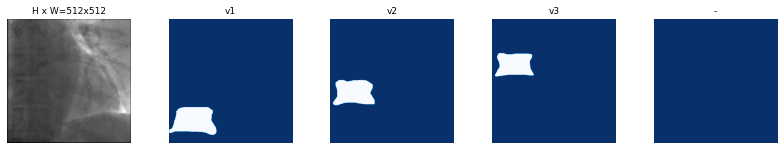

C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\datasets\spine_segmented_test\data\train\img\P00160003.tif


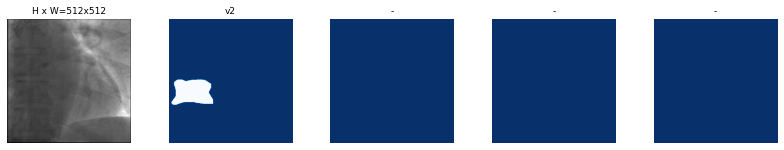

C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\datasets\spine_segmented_test\data\train\img\P00160006.tif


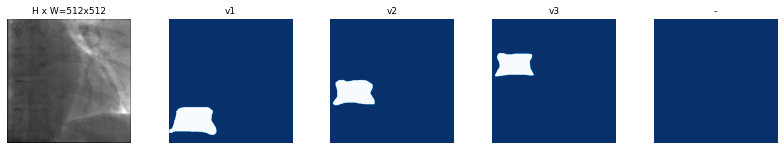

C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\datasets\spine_segmented_test\data\train\img\P00160007.tif


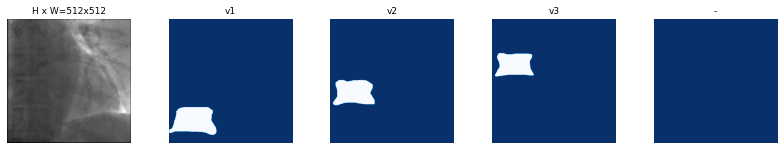

In [8]:
from skimage import data, io
from matplotlib import pyplot as plt

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
# print('Our image IDs are: ', image_ids)

# This is a sanity check to see if the images have loaded in
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     print(dataset_train.source_image_link(image_id))
#     io.imshow(image)
#     plt.show()
# print(dataset_train.class_names)

for image_id in image_ids:
    print(dataset_train.source_image_link(image_id))
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Initialize and Train Model

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=20, 
#             layers='heads')

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\logs\spine20200604T0336\mask_rcnn_spine_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\anaconda3\envs\cornell-mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/20
100/100 [==============================] - 92s 925ms/step - loss: 4.5245 - rpn_class_loss: 0.3105 - rpn_bbox_loss: 2.3606 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.8455 - mrcnn_mask_loss: 0.5752 - val_loss: 3.3704 - val_rpn_class_loss: 0.2366 - val_rpn_bbox_loss: 2.5292 - val_mrcnn_class_loss: 0.0275 - val_mrcnn_bbox_loss: 0.3045 - val_mrcnn_mask_loss: 0.2726

Epoch 2/20
100/100 [==============================] - 62s 617ms/step - loss: 3.0909 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 1.6399 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.6117 - mrcnn_mask_loss: 0.6102 - val_loss: 2.9437 - val_rpn_class_loss: 0.0809 - val_rpn_bbox_loss: 1.4160 - val_mrcnn_class_loss: 0.1238 - val_mrcnn_bbox_loss: 0.6928 - val_mrcnn_mask_loss: 0.6303
Epoch 3/20
100/100 [==============================] - 62s 624ms/step - loss: 2.9820 - rpn_class_loss: 0.1206 - rpn_bbox_loss: 1.5609 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.5831 - mrcnn_mask_loss: 0.6163 - val_loss: 2.8444 - val_

Epoch 20/20
100/100 [==============================] - 67s 666ms/step - loss: 1.2284 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.4777 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.3477 - val_loss: 1.7595 - val_rpn_class_loss: 0.0456 - val_rpn_bbox_loss: 0.9959 - val_mrcnn_class_loss: 0.1342 - val_mrcnn_bbox_loss: 0.2406 - val_mrcnn_mask_loss: 0.3432


In [9]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_spine_segment.h5")
model.keras_model.save_weights(model_path)

NameError: name 'model' is not defined

# Inference

In [10]:
class InferenceConfig(SpineConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\iFai1\Desktop\Cornell\MRCNN_Iteration\Mask_RCNN\logs\spine20200604T0336\mask_rcnn_spine_0020.h5




Re-starting from epoch 20


The following cell is just some prelimnary formatting to display images on the notebook. Change as you see fit for the image to be displayed in this notebook. This does not interfere with anything pertaining to our training/model.

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: spine.P00160006.tif (4) P00160006.tif
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  174.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   54.00000  max:  174.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
<class 'numpy.ndarray'>
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000


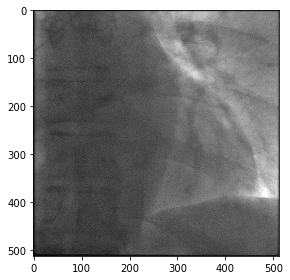

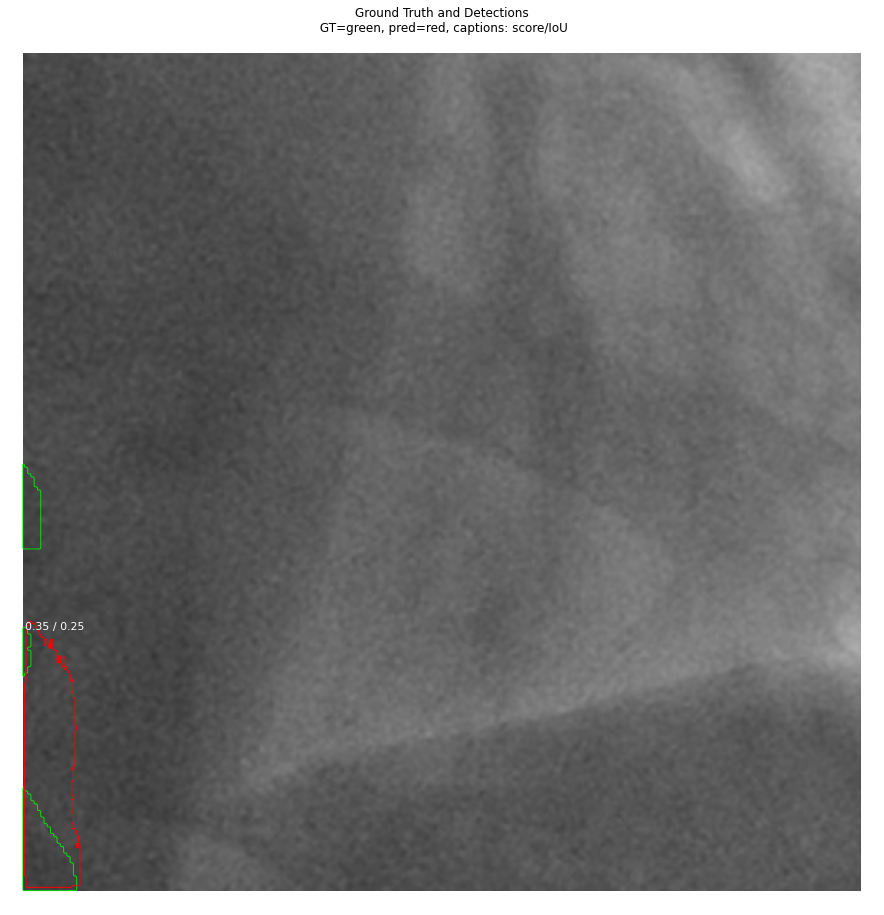

In [11]:
import random
from mrcnn.model import log
from matplotlib import pyplot as plt

dataset = dataset_train
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

#Load image for sanity
io.imshow(dataset_train.load_image(image_id))

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
print(type(gt_class_id))
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)